In this kernel we will go through a sentiment analysis on imdb dataset using LSTM.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import nltk
nltk.download("stopwords")
from tensorflow.keras.preprocessing.sequence import pad_sequences

!pip install paddlepaddle
import paddle

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Splitting to train and test data

We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.


In [ ]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


### Analysing sentiment

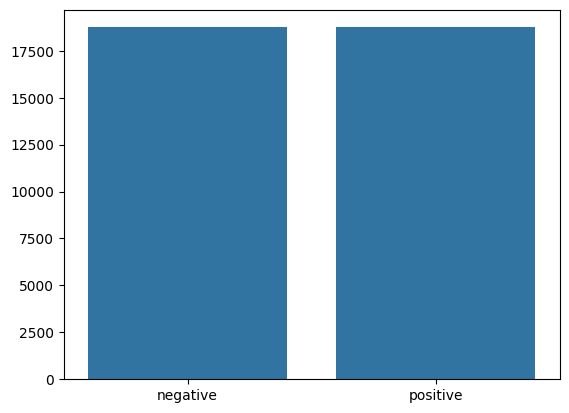

In [ ]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

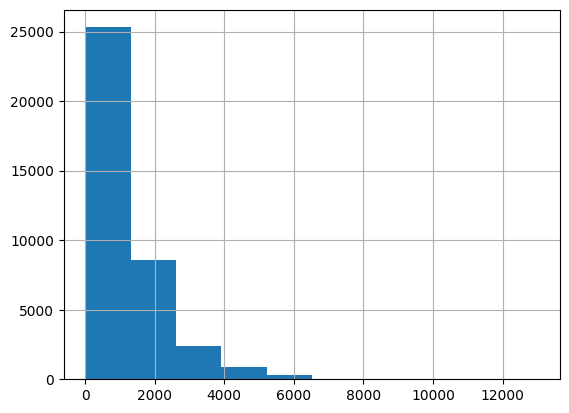

count    37500.000000
mean      1307.924347
std        989.514437
min         32.000000
25%        699.000000
50%        969.000000
75%       1588.000000
max      12988.000000
dtype: float64

In [ ]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Minimum length of review is seen to be 41, we can utilize this information to reduce the processing time for the model by simply taking a smaller range of length for each review during our data tokenization and cleaning process.

During the analysis and building of the model, I tried to keep the word length at 500, this caused the code to run for a really long time and eventually crash my system. I then reduced the length all the way down to 20 words, this did give me a good accuracy (about 75%) but I wanted to increase it a bit more to obtain the highest accuracy possible while also reducing the code run time, so I then tried with 100 words, this gave me an accuracy of about 80% which I was satisfied with but the run time was still too long so I then went ahead with 40 words looking at the shortest review. I then pad 10 zeros to the length to make the review length 50 even.

In [ ]:
bins = [0, 100, 200, 500, float('inf')]
labels = ['0-100', '101-200', '201-500', '500+']

# Categorize reviews based on length
df['review_length_category'] = pd.cut(df['sentence_length'], bins=bins, labels=labels)

# Group reviews by category and count them
grouped_df = df.groupby('review_length_category').size().reset_index(name='count')

# Print the results as a table
print(grouped_df.to_string())

### Tockenization

In [ ]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    # return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict
    # Pad the sequences in final_list_train and final_list_test
    padded_train = pad_sequences(final_list_train, maxlen=40)
    padded_test = pad_sequences(final_list_test, maxlen=40)

# Return the padded arrays
    return np.array(padded_train), np.array(encoded_train), np.array(padded_test), np.array(encoded_test), onehot_dict


In [ ]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [ ]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length to see if the padding worked

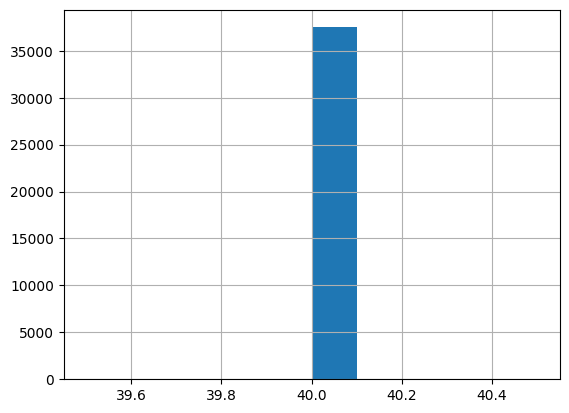

count    37500.0
mean        40.0
std          0.0
min         40.0
25%         40.0
50%         40.0
75%         40.0
max         40.0
dtype: float64

In [ ]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

### Padding

Now we will pad each of the sequence to max length

In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [ ]:
#padding to 50 for a good number
x_train_pad = padding_(x_train,50)
x_test_pad = padding_(x_test,50)


### Batching and loading as tensor

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.__next__()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 50])
Sample input: 
 tensor([[  0,   0,   0,  ..., 556, 268,  42],
        [  0,   0,   0,  ...,  35,  71, 765],
        [  0,   0,   0,  ..., 608, 217, 304],
        ...,
        [  0,   0,   0,  ...,  22,   5, 218],
        [  0,   0,   0,  ...,  18,  19, 214],
        [  0,   0,   0,  ..., 129, 474,   1]])
Sample input: 
 tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0])


We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

### Model

### Training

In [ ]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        # encoder_outputs shape: (batch_size, seq_len, hidden_dim)
        energy = self.projection(encoder_outputs)  # energy shape: (batch_size, seq_len, 1)
        weights = torch.softmax(energy.squeeze(-1), dim=1)  # weights shape: (batch_size, seq_len)
        # weights are the attention weights to be applied to the encoder_outputs

        # Apply attention weights to encoder_outputs
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)  # outputs shape: (batch_size, hidden_dim)

        return outputs

class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_dim,
                            num_layers=no_layers, batch_first=True)

        # Self-attention layer
        self.self_attention = SelfAttention(hidden_dim)

        # Dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # Linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        # Embeddings and lstm_out
        embeds = self.embedding(x)  # shape: (batch_size, seq_len, embedding_dim)
        lstm_out, hidden = self.lstm(embeds, hidden)  # lstm_out shape: (batch_size, seq_len, hidden_dim)

        # Apply self-attention
        attention_output = self.self_attention(lstm_out)  # attention_output shape: (batch_size, hidden_dim)

        # Dropout and fully connected layer
        out = self.dropout(attention_output)
        out = self.fc(out)

        # Sigmoid function
        sig_out = self.sig(out)

        # Reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1]  # Get last batch of labels

        # Return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden



no_layers = 2
vocab_size = len(vocab) + 1  # Extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256
drop_prob = 0.5

model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=drop_prob)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (self_attention): SelfAttention(
    (projection): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [ ]:


clip = 5
epochs = 4
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '/content/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')


Epoch 1
train_loss : 0.49608081193765 val_loss : 0.4048780506253242
train_accuracy : 75.064 val_accuracy : 81.22399999999999
Validation loss decreased (inf --> 0.404878).  Saving model ...
Epoch 2
train_loss : 0.38450532178084057 val_loss : 0.38100424045324327
train_accuracy : 82.75733333333334 val_accuracy : 82.696
Validation loss decreased (0.404878 --> 0.381004).  Saving model ...
Epoch 3
train_loss : 0.3465673111875852 val_loss : 0.37970220839977264
train_accuracy : 84.67466666666667 val_accuracy : 83.152
Validation loss decreased (0.381004 --> 0.379702).  Saving model ...
Epoch 4
train_loss : 0.3075887718200684 val_loss : 0.3961284449696541
train_accuracy : 86.81066666666666 val_accuracy : 82.704


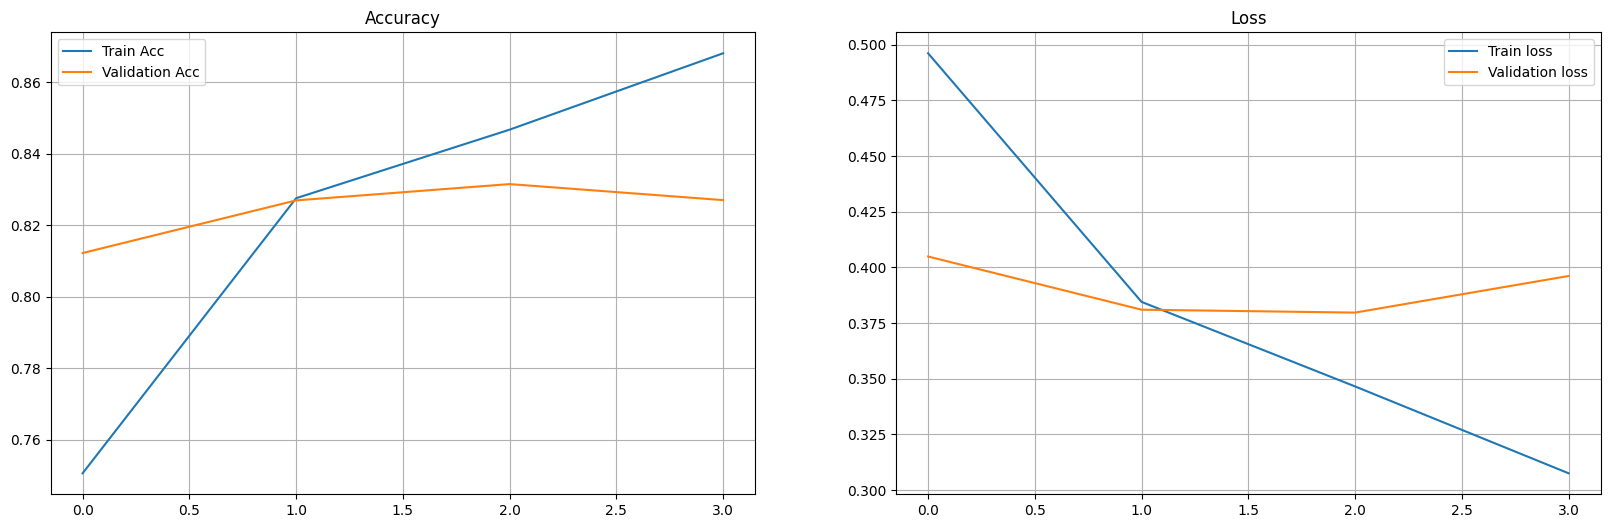

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

Accuracy over 80% is obtained by just 4 epochs, and also the loss is reduced by the end of the 4th epoch

### Inferance

In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [ ]:

index = 1888
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Absolutely nothing is redeeming about this total piece of trash, and the only thing worse than seeing this film is seeing it in English class. This is literally one of the worst films I have ever seen. It totally ignores and contradicts any themes it may present, so the story is just really really dull. Thank god the 80's are over, and god save whatever man was actually born as "James Bond III".
Actual sentiment is  : negative
Predicted sentiment is negative with a probability of 0.9962154631502926


In [ ]:

index = 39985
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

Some wonder why there weren't anymore Mrs. Murphy movies after this one. Will it's because this movie totally blew snot. Disney was not the right studio to run this film. MAYBE Touchstone (well, they're owned by Disney, but it'd be more adult). The film is too kid-ish, as the book series is not. The casting is all wrong for the characters. The characters don't even act the way they do in the books. And why was Tucker changed to a guy? He's a girl in the frigging books! Was this done to make the film appeal to boys? Sheesh. And where was Pewter, the gray cat? One of the funniest characters from the book is absent from this filth. Rita Mae Brown is a good writer, but letting Disney blow her work was wrong. An animated feature film, perhaps in the vane of Don Bluth's artwork would suit a better Mrs. Murphy film. Overall, I give this a 2, because at least Disney made a film from an under-appreciated book series. But, I wish they did better. Either way, I still have my books to entertain me


It is seen that using just 4 epochs for the training produced sufficient accuracy with our test data. Further improvements can be made to this by incorporating more LSTM layers and maybe using a larger length of review for training.
